<H1> Introduction to scPrisma- De novo reconstruction </h1>
<h1>Analysis of the cell cycle in HeLa S3 cells</h1>

This tutorial aims to provide a comprehensive overview of the scPrisma workflow, including the following steps:

1. Reconstruction of a target signal from scratch, utilizing only topological prior information.
3. Identification of genes related to the target signal, including the adjustment of a regularization parameter.
4. Enhancement of the desired signal, including the adjustment of a regularization parameter.
5. Filtering of the desired signal, including the adjustment of a regularization parameter.
The example used in this tutorial is based on HeLa S3 cells from <a href="https://doi.org/10.15252/msb.20209946">Schwabe, Daniel, et al. Molecular systems biology(2020)
</a>. 
<br />
The data can be download from <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4224315" >here</a>.



In [1]:
#######imports and data read#######
import copy
import time
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import scPrisma
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
adata = sc.read_csv('./GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T

WARNING! Torch is not installed! Falling back to numba for cpu-only execution.
For utilizing gpu please install scPrisma like so pip install .[gpu]


<h2>Standard pre-processing</h2> <br />
Using a standard single-cell RNA-seq pre-processing pipeline involving normalization of counts per cell, log(1+x) over the entire data and selection of highly variable genes is highly recommended. 

Gene selection is important when trying to reconstruct a cyclic signal de novo (without prior knowledge).

Scaling the genes to zero mean and variance of one is not mandatory.



In [2]:
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
orig_adata  = adata.copy()
sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)

Note: it is possible

<h3>De novo- reconstruction</h3>

In [3]:
E_sga  , E_rec_sga = scPrisma.algorithms.reconstruction_cyclic(adata.X , iterNum=100)


Iteration number: 
0
 function value= 
2.5375017018020108e-23
Iteration number: 
25
 function value= 
421.59828328441336
Iteration number: 
50
 function value= 
637.0314078694922
Iteration number: 
75
 function value= 
648.4634440663344


In [4]:
sga_range= scPrisma.algorithms.e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())

To validate that the reconstruction algorithm indeed converged to the cell cycle signal we will use 3 different phase marker genes. Peaktimes were taken from <a href="https://cyclebase.org/">Cyclebase</a>. <br />
"CCNE2"- Peaktime at 'S' phase.<br />
"CDK1"- Peaktime at 'G2' phase.<br />
"CDC20"- Peaktime at 'M' phase.

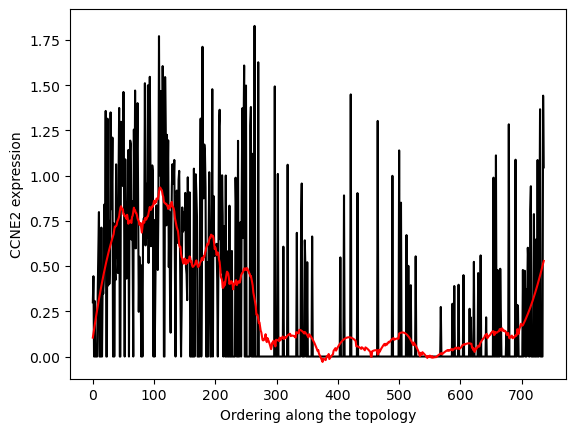

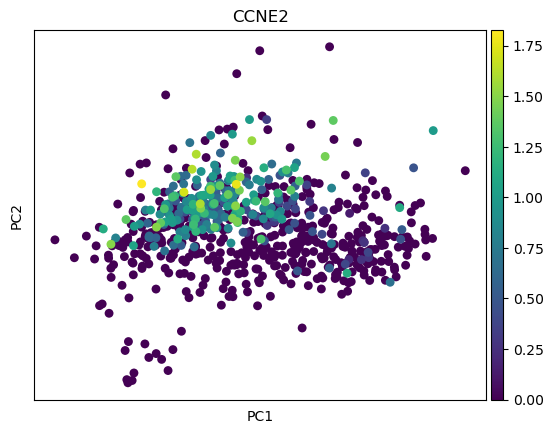

In [6]:
plt.plot(adata[:,"CCNE2"].X[:,0],color='black') #Peaktime at S
plt.plot(savgol_filter(adata[:,"CCNE2"].X[:,0],70,2), color='r')

plt.ylabel('CCNE2 expression')
plt.xlabel('Ordering along the topology')
plt.show()
sc.pp.pca(adata)
sc.pl.pca(adata, color=['CCNE2'])

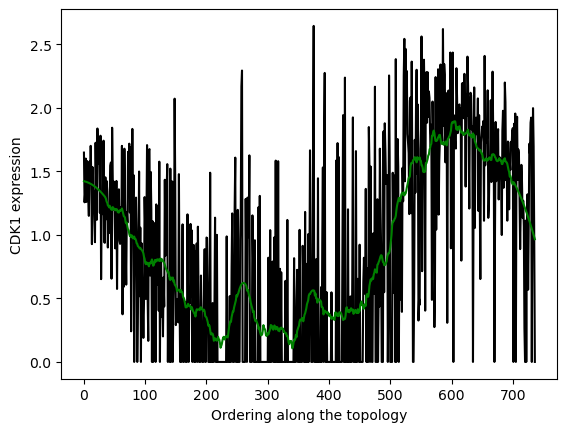

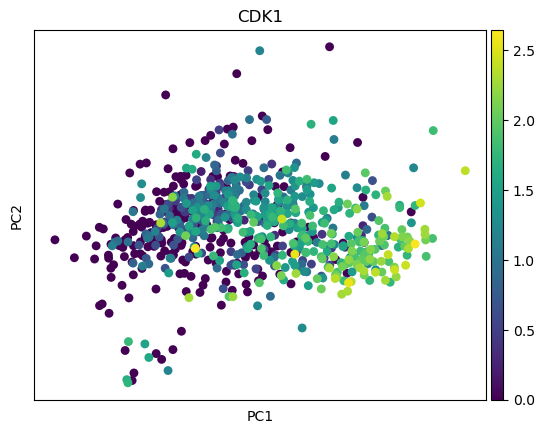

In [8]:
plt.plot(adata[:,"CDK1"].X[:,0],color='black') #Peaktime at G2
plt.plot(savgol_filter(adata[:,"CDK1"].X[:,0],70,2), color='g')

plt.ylabel('CDK1 expression')
plt.xlabel('Ordering along the topology')
plt.show()
sc.pl.pca(adata, color=['CDK1'])

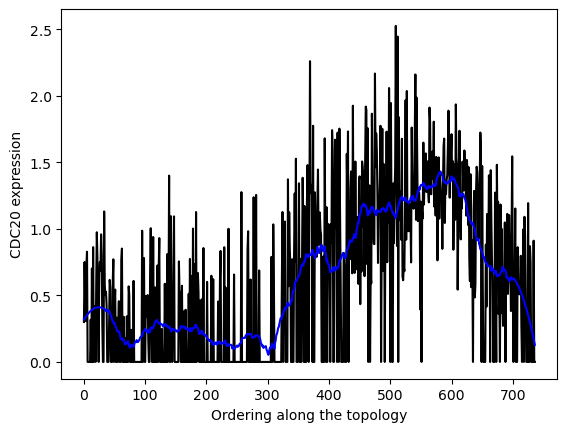

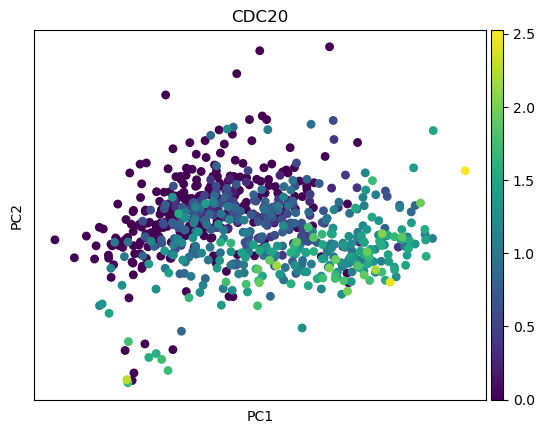

In [7]:
plt.plot(adata[:,"CDC20"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata[:,"CDC20"].X[:,0],70,2), color='b')

plt.ylabel('CDC20 expression')
plt.xlabel('Ordering along the topology')
plt.show()
sc.pl.pca(adata, color=['CDC20'])

<h2> B- Enhancement workflow</h2>
<h3> B.1 Genes inference</h3>
Having obtained the reconstructed signal, either through the reconstruction problem or from prior knowledge, we will next identify the informative genes that are related to the desired signal.

Due to convexity considerations, it is easier to infer genes that are not related to the desired signal, and then flip the results. 

The regularization parameter is the only parameter that should be tuned. By keeping a large value, the "filter_cyclic_genes" algorithm would keep more cyclic genes, which would then be filtered later by flipping.

It can be optimized manually, or by choosing a fixed number of genes to preserve according to their projection (as been shown <a href="https://github.com/nitzanlab/scPrisma/blob/master/tutorials/hematopoietic_progenitors_reconstruction_with_partial_prior_knowledge.ipynb">here</a>). In this case, we will choose a value that maintains most of the genes, and validate that a 'flat' gene ("AASDHPPT", as defined by "Cycle base") is removed and a smooth gene ("CDC20") is kept.

For example: Using regularization of 0 keeps all genes.

Iteration number: 
1
function value= 
423.8178626440208
Iteration number: 
26
function value= 
36.846831491029505
Iteration number: 
51
function value= 
10.839594081209464
Iteration number: 
76
function value= 
4.729155499049779


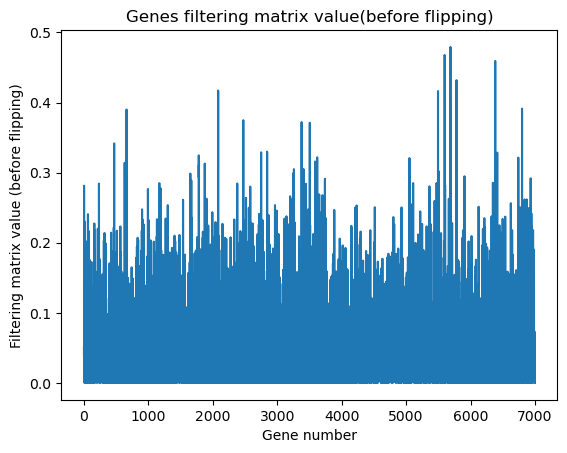

In [9]:
D = scPrisma.algorithms.filter_cyclic_genes(adata.X,regu=0, iterNum=100)
plt.plot(D.diagonal())
plt.xlabel("Gene number")
plt.ylabel("Filtering matrix value (before flipping)")
plt.title("Genes filtering matrix value(before flipping)")
plt.show()

For example: Using regularization of 1 filters out most genes.

Iteration number: 
1
function value= 
640.6495892843976
Iteration number: 
26
function value= 
1555.8111321770866
Iteration number: 
51
function value= 
1565.2479294344555
Iteration number: 
76
function value= 
1565.940381089415


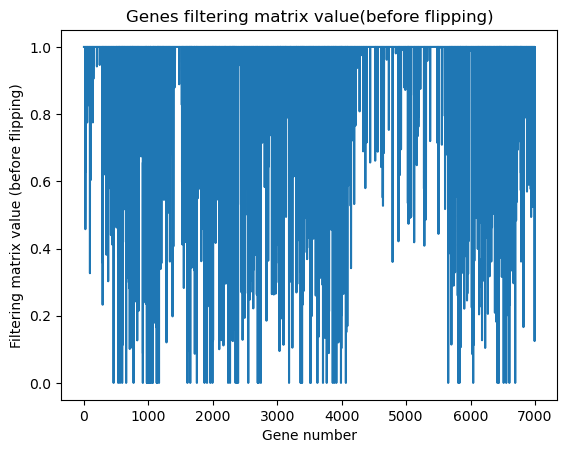

In [10]:
D = scPrisma.algorithms.filter_cyclic_genes(adata.X,regu=1, iterNum=100)
plt.plot(D.diagonal())
plt.xlabel("Gene number")
plt.ylabel("Filtering matrix value (before flipping)")
plt.title("Genes filtering matrix value(before flipping)")
plt.show()

For example: Using regularization of 0.2 indeed both keeps and filters arge number of genes.

Iteration number: 
1
function value= 
463.36532393334306
Iteration number: 
26
function value= 
274.6847036285519
Iteration number: 
51
function value= 
290.78737284883994
Iteration number: 
76
function value= 
303.32536658153197


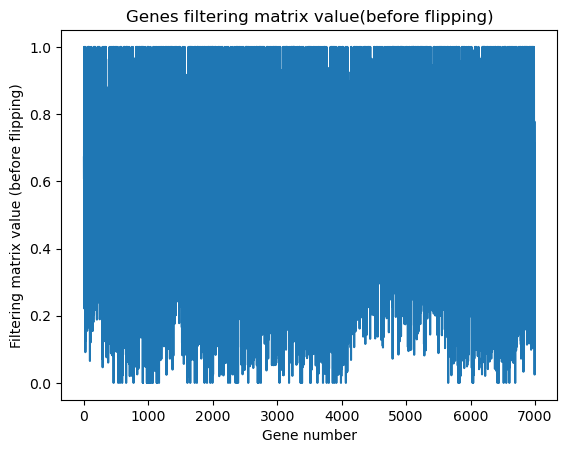

In [11]:
D = scPrisma.algorithms.filter_cyclic_genes(adata.X,regu=0.2, iterNum=100)
plt.plot(D.diagonal())
plt.xlabel("Gene number")
plt.ylabel("Filtering matrix value (before flipping)")
plt.title("Genes filtering matrix value(before flipping)")
plt.show()

Remember to flip before applying the filtering.

In [12]:
D_flipped = np.identity(D.shape[0])-D
adata_enhancement = adata.copy()
adata_enhancement.X = adata_enhancement.X.dot(D_flipped)

We can see that 'CDC20' was not filtered out, while "AASDHPPT" was filtered out.

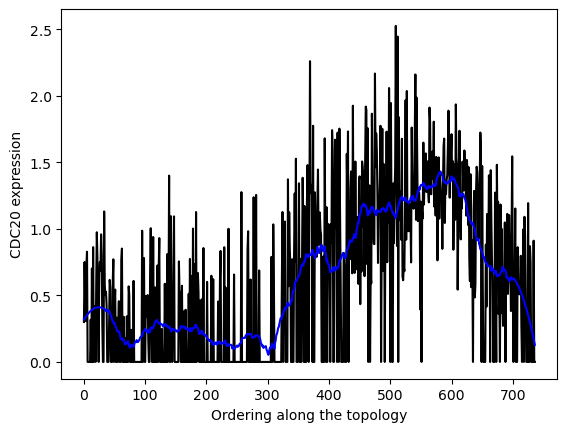

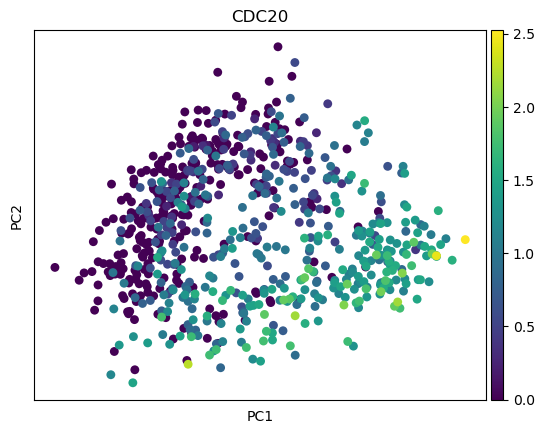

In [13]:
plt.plot(adata_enhancement[:,"CDC20"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_enhancement[:,"CDC20"].X[:,0],70,2), color='b')

plt.ylabel('CDC20 expression')
plt.xlabel('Ordering along the topology')
plt.show()
sc.pp.pca(adata_enhancement)
sc.pl.pca(adata_enhancement, color=['CDC20'])

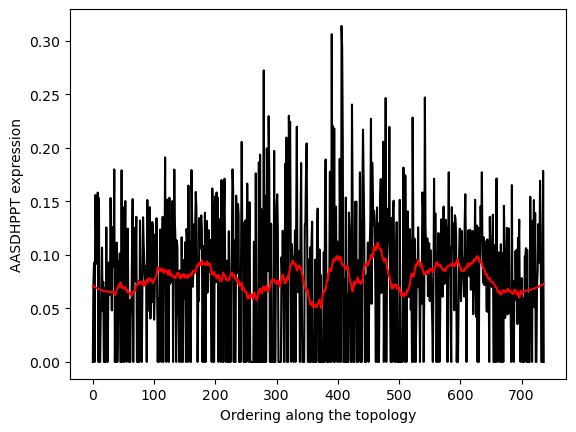

In [14]:
plt.plot(adata_enhancement[:,"AASDHPPT"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_enhancement[:,"AASDHPPT"].X[:,0],70,2), color='r')

plt.ylabel('AASDHPPT expression')
plt.xlabel('Ordering along the topology')
plt.show()

<h3> B.2 Cyclic enhancement</h3>
Having only the genes which are smooth over the inferred topology. We will now filer the expressio profiles which are unrelated to the cell cycle.

Here we also need to tune the regularization parameter. Higher regularization will filter out more expression profiles which are not related to the reconstructed signal, which can also be validated using marker genes(such as 'CDC20').<br />
We highly recommend using as little regularization as possible to avoid overfitting.
We can also take a look at the filtering matrix and ensure that it is not zeros matrix.

Iteration number: 
1
function value: 
1860.7263267171784
Iteration number: 
26
function value: 
3411.307689186688
Iteration number: 
51
function value: 
5162.612142279347
Iteration number: 
76
function value: 
6371.0336238702575


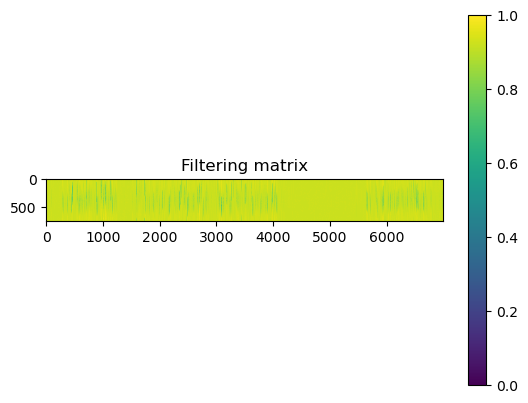

In [15]:
F = scPrisma.algorithms.enhancement_cyclic(adata_enhancement.X,regu=0.01,iterNum=100)

plt.imshow(F)
plt.title("Filtering matrix")
plt.colorbar()
plt.show()

In [16]:
adata_enhancement.X = adata_enhancement.X * F

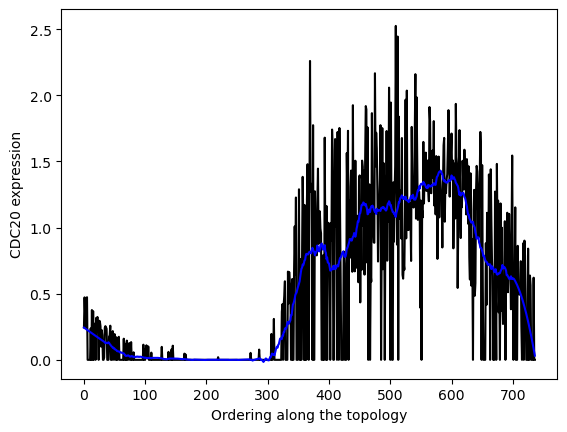

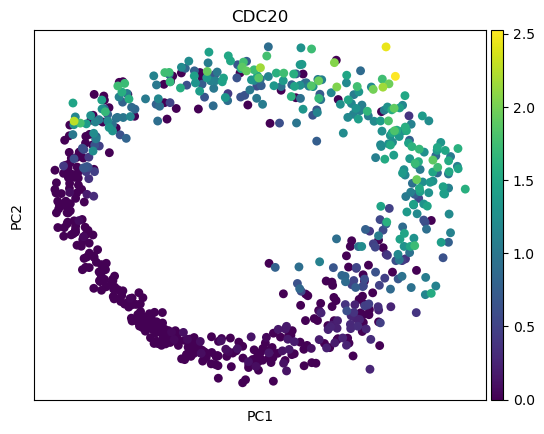

In [17]:
plt.plot(adata_enhancement[:,"CDC20"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_enhancement[:,"CDC20"].X[:,0],70,2), color='b')

plt.ylabel('CDC20 expression')
plt.xlabel('Ordering along the topology')
plt.show()
sc
sc.pp.pca(adata_enhancement)
sc.pl.pca(adata_enhancement, color=['CDC20'])

<h3>C. Cyclic signal filtering</h3>
If insead of enhancing the reconstructed signal, we want to filter it out we can use the cyclic filtering algorithm.

Here, we also have a regularization parameter, higher regularization will keep more expression profiles.

In [18]:
adata_filtered = copy.deepcopy(adata.copy())
F = scPrisma.algorithms.filtering_cyclic(adata_filtered.X,regu=0,iterNum=300)


starting filtering
25
th Iteration    Loss :: 
132.02640841971072
50
th Iteration    Loss :: 
66.23040454647084
75
th Iteration    Loss :: 
45.73317023750903
100
th Iteration    Loss :: 
35.2346733139572
125
th Iteration    Loss :: 
29.16350401587004
150
th Iteration    Loss :: 
24.98104485134164
175
th Iteration    Loss :: 
22.095905706573525
200
th Iteration    Loss :: 
19.790800824169835
225
th Iteration    Loss :: 
18.009837402408678
250
th Iteration    Loss :: 
16.608873427938207
275
th Iteration    Loss :: 
15.457718268298875
300
th Iteration    Loss :: 
14.478677560825766


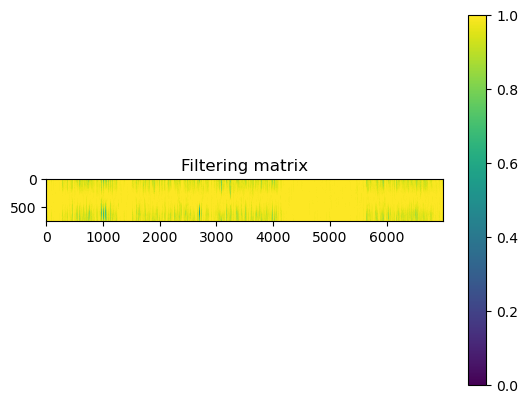

In [19]:
plt.imshow(F)
plt.title("Filtering matrix")
plt.colorbar()
plt.show()

In [20]:
adata_filtered.X = adata_filtered.X * F


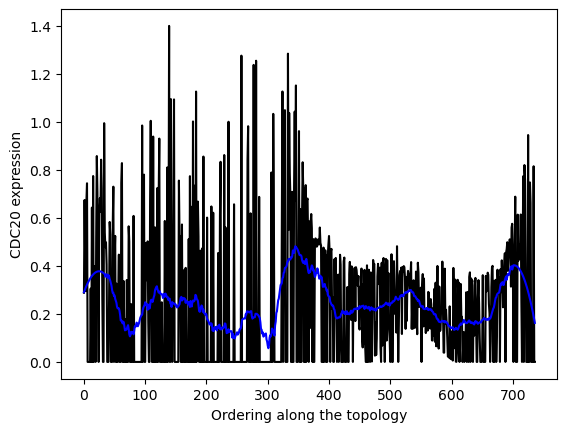

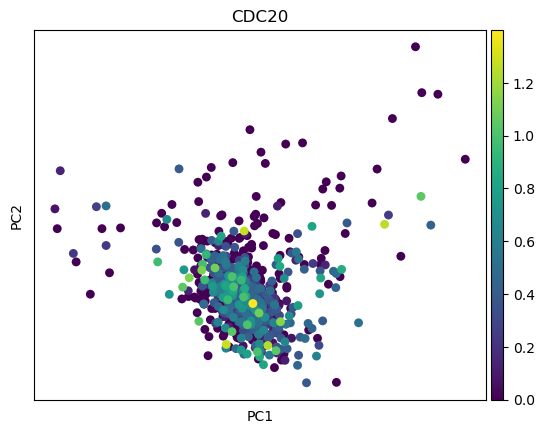

In [21]:
plt.plot(adata_filtered[:,"CDC20"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_filtered[:,"CDC20"].X[:,0],70,2), color='b')

plt.ylabel('CDC20 expression')
plt.xlabel('Ordering along the topology')
plt.show()
sc.pp.pca(adata_filtered)
sc.pl.pca(adata_filtered, color=['CDC20'])